# Обучение сверточной нейросетевой модели для задачи классификации заболеваний дачных растений

Определим основные зависимости:
1. os - модуль Python для работы с файловой системой. Потребуется для поиска по структуре датасета;
2. tqdm - создание прогресс-баров в циклах для осущствления принципа ясного статуса системы;
3. matplotlib - библиотека для визуализации данных. Необходима для визуальных демонстраций различного назначения;
4. torch и  torchvision - основные библиотеки в экосистеме PyTorch для глубокого обучения
5. sklearn - библиотека для машинного обучения

In [1]:
import os

import random
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchinfo

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Гиперпараметры
- Размер входного изображения – 224x224, – соответствует стандарту для большинства CNN архитектур;
- Batch size – 24, – выбран как максимально возможный в условиях ограниченной видеопамяти;
- Начальная скорость обучения – 1e-3, минимальная – 1е-6
- Weight decay – 1е-4, для оптимизатора AdamW (поддержка L2 регуляризации для стабилизации обучения)
- Продолжительность обучения – 20 эпох
- Период косинуса для планировщика – 30 эпох (1.5 * продолжительность)

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 24

INITIAL_LR = 0.001
MIN_LR = 1e-6
WEIGHT_DECAY = 1e-4

EPOCHS = 20
COS_CYCLE_EPOCH = 30

При желании можно задать seed для воспроизводимости определенного сценария обучения

In [3]:
SEED = 44

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

generator = torch.Generator()
generator.manual_seed(SEED)

## Подготовка данных для обучения модели

### 1. Источник данных
Укажем путь до сформированного набора данных в переменной dataset_dir

In [4]:
dataset_dir = "./result_dataset/"

### 2. Нормализация
Опишем характер процедуры нормализации (normalize_transform) на основе сведений (mean и std) из предыдущей работы

In [5]:
normalize_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(
        mean=[0.41921298, 0.52113469, 0.30923691],
        std=[0.24287073, 0.2497224, 0.24061386]
    ),
]) 

### 3. Формирование выборок
На основе разделения данных по соответсвующим директориям формируем выборки Train, Validation и Test

In [6]:
train_dir = os.path.join(dataset_dir, 'Train')
valid_dir = os.path.join(dataset_dir, 'Validation')
test_dir = os.path.join(dataset_dir, 'Test')

train_data = datasets.ImageFolder(train_dir, normalize_transform)
valid_data = datasets.ImageFolder(valid_dir, normalize_transform)
test_data = datasets.ImageFolder(test_dir, normalize_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(train_data.classes)
print(train_data.class_to_idx)

['Healthy', 'Powdery', 'Rust', 'Slug', 'Spot']
{'Healthy': 0, 'Powdery': 1, 'Rust': 2, 'Slug': 3, 'Spot': 4}


## Выбор устройства обучения
Определим тип устройства, на основе которого будет проведено обучение модели. Приоритет отдается GPU при его доступности

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Объявление модели
Для обучения объявим модель (в данном случае, efficientNet) и определим структуру выходного слоя в качестве 5 нейронов, соотвествующих числу классов в выборке. После чего переведем модель на выборнное устройство

In [18]:
output = len(train_data.classes)

model = torchvision.models.efficientnet_b1()
model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=output)
model = model.to(device)

SAVE_NAME = "eff-net-b1"
torchinfo.summary(model, (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [24, 5]                   --
├─Sequential: 1-1                                       [24, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [24, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [24, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [24, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [24, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [24, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [24, 16, 112, 112]        1,448
│    │    └─MBConv: 3-5                                 [24, 16, 112, 112]        612
│    └─Sequential: 2-3                                  [24, 24, 56, 56]          --
│    │    └─MBConv: 3-6                                

## Подготовка к обучению
Для формирования цикла обучения необходимо определить:
- функцию потерь, предназначенная для классификации, например, кросс-энтропия
- оптимизатор: AdamW - улучшенная версия Adam с правильной L2 регуляризацией (техника для предотвращения переобучения)
- планироващик скорости обучения: Косинусный для плавного изменения скорости обучения

In [9]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY) 
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=COS_CYCLE_EPOCH, eta_min=MIN_LR)

## Обучение
Определяем префикс имени сохранения и вспомогательные структуры для визуализации процесса обучения

In [10]:
train_loss = [] 
train_accuracy = []

valid_loss = []
valid_accuracy = []

learn_rate = []

best_valid_accuracy = 0

if not os.path.exists('./saves'):
    os.mkdir('./saves')

for epoch in range(EPOCHS): 

    # Процесс обучения на тренировочной выборке
    model.train() 
    
    running_train_loss = []  
    train_correct = 0    

    train_loop = tqdm(train_loader, leave=False)
    for batch, labels in train_loop: 

        batch = batch.to(device)
        labels = labels.to(device)

        outputs = model(batch)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)    
        train_correct += (predicted == labels).sum().item()   

        running_train_loss.append(loss.item())

        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] - train')
        
    train_loss.append(sum(running_train_loss) / len(running_train_loss))
    train_accuracy.append(train_correct/ len(train_data))
 
    # Оценка обученности модели при помощи выборки Validation
    model.eval()

    running_valid_loss = []  
    valid_correct = 0    

    with torch.no_grad():

        valid_loop = tqdm(valid_loader, leave=False)
        for batch, labels in valid_loop:

            batch = batch.to(device)
            labels = labels.to(device)

            outputs = model(batch)
            loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)    
            valid_correct += (predicted == labels).sum().item()  

            running_valid_loss.append(loss.item())

            valid_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] - valid')

        valid_loss.append(sum(running_valid_loss) / len(running_valid_loss))
        valid_accuracy.append(valid_correct/ len(valid_data))

        lr = lr_scheduler._last_lr[0]
        learn_rate.append(lr)
        lr_scheduler.step()

    #Вывод результатов работы обучения модели на заданной эпохе
    print(f'Epoch [{epoch + 1}/{EPOCHS}]', end=' ')
    print(f"train_loss = {train_loss[-1]:.4f}", end=' ')
    print(f"train_acc = {train_accuracy[-1]:.4f}", end=' ')
    print(f"valid_loss = {valid_loss[-1]:.4f}", end=' ')
    print(f"valid_acc = {valid_accuracy[-1]:.4f}", end=' ')
    print(f"lr = {learn_rate[-1]}")

    target_accuracy = valid_accuracy[-1]

    #Сохранение более совершенной модели
    if (target_accuracy > best_valid_accuracy):

        print('Saving model...', end=' ')
        torch.save(model, f'./saves/{SAVE_NAME}-{(target_accuracy * 100):.0f}-{epoch+1}.pt')
        print('...Model saved')

        best_valid_accuracy = target_accuracy  


Epoch [1/20] train_loss = 1.3666 train_acc = 0.3785 valid_loss = 1.2072 valid_acc = 0.4920 lr = 0.001
Saving model... ...Model saved


Epoch [2/20] train_loss = 1.0846 train_acc = 0.5065 valid_loss = 1.0035 valid_acc = 0.6130 lr = 0.0009972636867364526
Saving model... ...Model saved


Epoch [3/20] train_loss = 0.8435 train_acc = 0.6661 valid_loss = 0.7448 valid_acc = 0.7310 lr = 0.000989084726566536
Saving model... ...Model saved


Epoch [4/20] train_loss = 0.7217 train_acc = 0.7255 valid_loss = 0.7559 valid_acc = 0.7320 lr = 0.0009755527298894295
Saving model... ...Model saved


Epoch [5/20] train_loss = 0.6071 train_acc = 0.7749 valid_loss = 0.6361 valid_acc = 0.7520 lr = 0.0009568159560924792
Saving model... ...Model saved


Epoch [6/20] train_loss = 0.5379 train_acc = 0.8083 valid_loss = 0.5357 valid_acc = 0.7850 lr = 0.0009330796891903274
Saving model... ...Model saved


Epoch [7/20] train_loss = 0.4777 train_acc = 0.8249 valid_loss = 0.4134 valid_acc = 0.8540 lr = 0.0009046039886902865
Saving model... ...Model saved


Epoch [8/20] train_loss = 0.4385 train_acc = 0.8420 valid_loss = 0.8827 valid_acc = 0.7550 lr = 0.0008717008403259585


Epoch [9/20] train_loss = 0.4827 train_acc = 0.8244 valid_loss = 0.5246 valid_acc = 0.8000 lr = 0.0008347307378762498


Epoch [10/20] train_loss = 0.3809 train_acc = 0.8676 valid_loss = 0.4562 valid_acc = 0.8240 lr = 0.0007940987335200904


Epoch [11/20] train_loss = 0.3387 train_acc = 0.8835 valid_loss = 0.4276 valid_acc = 0.8420 lr = 0.00075025


Epoch [12/20] train_loss = 0.2959 train_acc = 0.8921 valid_loss = 0.4222 valid_acc = 0.8490 lr = 0.0007036649532163624


Epoch [13/20] train_loss = 0.2910 train_acc = 0.8985 valid_loss = 0.3866 valid_acc = 0.8710 lr = 0.0006548539886902864
Saving model... ...Model saved


Epoch [14/20] train_loss = 0.2455 train_acc = 0.9121 valid_loss = 0.3747 valid_acc = 0.8710 lr = 0.0006043518895634709


Epoch [15/20] train_loss = 0.2149 train_acc = 0.9219 valid_loss = 0.3937 valid_acc = 0.8690 lr = 0.0005527119674021931


Epoch [16/20] train_loss = 0.1803 train_acc = 0.9373 valid_loss = 0.3515 valid_acc = 0.8720 lr = 0.0005005000000000002
Saving model... ...Model saved


Epoch [17/20] train_loss = 0.1807 train_acc = 0.9405 valid_loss = 0.3588 valid_acc = 0.8780 lr = 0.00044828803259780724
Saving model... ...Model saved


Epoch [18/20] train_loss = 0.1361 train_acc = 0.9556 valid_loss = 0.3878 valid_acc = 0.8650 lr = 0.0003966481104365292


Epoch [19/20] train_loss = 0.1104 train_acc = 0.9643 valid_loss = 0.4630 valid_acc = 0.8720 lr = 0.00034614601130971383


Epoch [20/20] train_loss = 0.0945 train_acc = 0.9682 valid_loss = 0.4394 valid_acc = 0.8720 lr = 0.00029733504678363786


## Анализ обучения

### 1. Визулизация процесса обучени
Оторажаем на графиках, как изменялись ошибка и точность модели на Train и Validation выборках, а также скорость обучения с каждой эпохой.

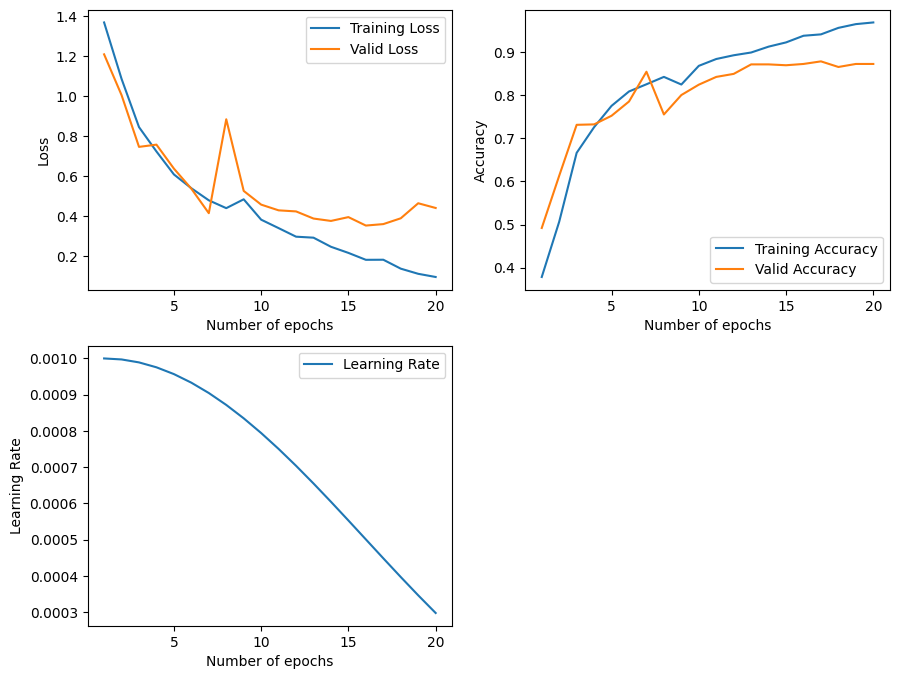

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.plot(range(1,len(train_loss)+1), train_loss, label="Training Loss") 
plt.plot(range(1,len(valid_loss)+1), valid_loss, label="Valid Loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("Loss") 
plt.legend(loc='upper right')

plt.subplot(2, 3, 2)
plt.plot(range(1,len(train_accuracy)+1), train_accuracy, label="Training Accuracy")
plt.plot(range(1,len(valid_accuracy)+1), valid_accuracy, label="Valid Accuracy")
plt.xlabel("Number of epochs") 
plt.ylabel("Accuracy") 
plt.legend(loc='lower right')

plt.subplot(2, 3, 4)
plt.plot(range(1,len(learn_rate)+1), learn_rate, label="Learning Rate")
plt.xlabel("Number of epochs") 
plt.ylabel("Learning Rate") 
plt.legend(loc='upper right')
plt.show()

### 2. Проверка на тестовых данных
Для оценки модели на тестовых данных произведем расчет таких показетелей как:
- Precision - показывает, насколько можно доверять модели, когда она предсказывает положительный класс. Отражает долю правильно предсказанных положительных примеров среди всех примеров;
- Recall - показывает, какую долю всех реально положительных примеров модель смогла обнаружить и правильно классифицировать;
- F1-score - это гармоническое среднее между Precision и Recall.

In [ ]:
model = torch.load('./saves/eff-net-b1-88-17.pt', weights_only=False).to(device)

In [16]:
model.eval()

y_true = []
y_pred =  []

with torch.no_grad():

    for batch, labels in test_loader:

        batch = batch.to(device)
        labels = labels.to(device)

        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1)    


        y_true += [i.item() for i in labels]
        y_pred += [i.item() for i in predicted]

print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.864     0.920     0.891       200
           1      0.954     0.935     0.944       200
           2      0.974     0.950     0.962       200
           3      0.888     0.915     0.901       200
           4      0.842     0.800     0.821       200

    accuracy                          0.904      1000
   macro avg      0.905     0.904     0.904      1000
weighted avg      0.905     0.904     0.904      1000



Также полученные численные метрики удобно представить в виде матрицы ошибок

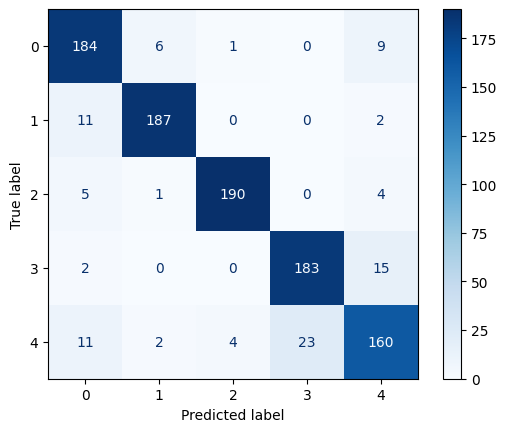

In [17]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()